## Setup Python Path for Imports

In [2]:
import sys
import os

# This allows us to import files from the src/ folder while running the notebook
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

## Import packages

In [4]:
import pandas as pd
import numpy as np
import chardet
import re
import emoji

## Load and Filter Indo Hate Speech Dataset

In [6]:
# Load Excel
file_path = "../data/raw/Indo-HateSpeech_Dataset.xlsx"
xls = pd.ExcelFile(file_path)
df = xls.parse("PostID Edited Comments Hindi")

# Keep only comment and label
hatespeech_df = df[["Comment", "Label"]].copy()

# Clean and map labels
hatespeech_df["Label"] = hatespeech_df["Label"].astype(str).str.strip("'").map({"HS0": 0, "HS1": 1})
hatespeech_df = hatespeech_df.dropna(subset=["Label"])
hatespeech_df["Label"] = hatespeech_df["Label"].astype(int)

# Rename columns
hatespeech_df = hatespeech_df.rename(columns={
    "Comment": "Code mixed text",
    "Label": "Hate or Non Hate speech"
})

# Drop rows with missing comments
hatespeech_df = hatespeech_df.dropna(subset=["Code mixed text"])

# Convert to string explicitly
hatespeech_df["Code mixed text"] = hatespeech_df["Code mixed text"].astype(str)

# Function to check if all words are in English
def is_english_only(text):
    return all(re.match("^[a-zA-Z]+$", word) for word in text.split())

# Apply filter
english_only_df = hatespeech_df[hatespeech_df["Code mixed text"].apply(is_english_only)]

# Reset index
english_only_df = english_only_df.reset_index(drop=True)

# Preview
print(english_only_df.dtypes)
print(english_only_df.head())


Code mixed text            object
Hate or Non Hate speech     int64
dtype: object
                                     Code mixed text  Hate or Non Hate speech
0  Nice buro yes I am Hussain khan is me happy ow...                        0
1                                            Send me                        0
2  Ye india ke sare muslman babar or akbar ki naj...                        0
3                                   Teri maa ki chut                        1
4                           owesi ki maa kaa cholaaa                        0


In [7]:
df = pd.read_csv("../data/raw/hate_speech.tsv", sep="\t", header=None)
df.columns = ["Code mixed text", "Hate or Non Hate speech"]

# Drop NaNs, filter valid labels
df = df.dropna()
df = df[df["Hate or Non Hate speech"].isin(["yes", "no"])]
df["Hate or Non Hate speech"] = df["Hate or Non Hate speech"].map({"yes": 1, "no": 0})
df.head()

,Code mixed text,Hate or Non Hate speech
0,Knowing ki Vikas kitna samjhata hai Priyanka a...,0
1,I am Muhajir .. Aur mere lye sab se Pehly Paki...,0
2,Doctor sab sahi me ke PhD (in hate politics) ...,0
3,Poore Desh me Patel OBC me aate Hain sirf gujr...,0
4,Sarkar banne ke bad Hindu hit me ek bhi faisla...,1


In [8]:
hatespeech_df = pd.concat([hatespeech_df, df], ignore_index=True)


## Clean Text and Extract Profanity Features

In [10]:
from src.utils.profanity_utils import load_profanity_dict, extract_profanity_features
from src.preprocessing.text_cleaning import clean_text

# Load the profanity dictionary with severity scores
profanity_dict = load_profanity_dict("../data/raw/Hinglish_Profanity_List.csv")

# Clean the code-mixed text (lowercase, remove URLs, emojis, etc.)
hatespeech_df["Cleaned"] = hatespeech_df["Code mixed text"].astype(str).apply(clean_text)

# Extract features like count, severity, match flag, and length
hatespeech_df[["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]] = \
    hatespeech_df["Cleaned"].apply(lambda x: pd.Series(extract_profanity_features(x, profanity_dict)))

## Visualize the types of all features in both datasets.

In [12]:
hatespeech_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78442 entries, 0 to 78441
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Code mixed text          78442 non-null  object 
 1   Hate or Non Hate speech  78442 non-null  int64  
 2   Cleaned                  78442 non-null  object 
 3   profanity_count          78442 non-null  float64
 4   profanity_score          78442 non-null  float64
 5   binary_profanity_match   78442 non-null  float64
 6   normalized_text_len      78442 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.2+ MB


## Check for any existing missing values and drop those rows.

In [14]:
hatespeech_df[hatespeech_df.isnull().any(axis=1)].shape[0]
hatespeech_df.dropna(inplace=True)

## Check the number of rows in each label.

In [16]:
hatespeech_df["Hate or Non Hate speech"].value_counts()

Hate or Non Hate speech
0    65748
1    12694
Name: count, dtype: int64

## Drop indices and Check the imbalance between labels

In [18]:
hatespeech_df = hatespeech_df.reset_index(drop=True)
hatespeech_df["Hate or Non Hate speech"].value_counts()

Hate or Non Hate speech
0    65748
1    12694
Name: count, dtype: int64

## Apply Profanity Feature Extraction and Preview Results

In [20]:
# Load the profanity dictionary with fuzzy-safe normalization
profanity_dict = load_profanity_dict("../data/raw/Hinglish_Profanity_List.csv")

# (Optional) Preview a few entries to confirm it's loaded correctly
print(dict(list(profanity_dict.items())[:10]))

# Extract context-aware profanity features from the cleaned text
# Only counts profane words if used with personal references
hatespeech_df[["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]] = \
    hatespeech_df["Cleaned"].apply(lambda x: pd.Series(extract_profanity_features(x, profanity_dict)))

# Drop raw (uncleaned) text column — not needed anymore
hatespeech_df.drop(columns=["Code mixed text"], inplace=True)

# Preview a few extracted feature rows
print(hatespeech_df[["Cleaned", "profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]].sample(5, random_state=42))

# Preview full rows from final dataset
hatespeech_df.sample(5, random_state=42)


{'badir': 1, 'badirchand': 1, 'bakland': 1, 'bhadva': 2, 'bhootnika': 3, 'chinaal': 7, 'chup': 1, 'chutia': 5, 'ghasti': 4, 'chutiya': 5}
                                                 Cleaned  profanity_count  \
44877                           lawde ka jhula hain yeh               0.0   
4869   iski dhajjiya na udd gyi to kehna mahadev inka...              0.0   
26632                                     jay shree ram               0.0   
54518                                    रम जय शर हर कषण              0.0   
1491   iski maa 1000 katwe ka kondam  kha kar peada k...              0.0   

       profanity_score  binary_profanity_match  normalized_text_len  
44877              0.0                     0.0                 0.05  
4869               0.0                     0.0                 0.23  
26632              0.0                     0.0                 0.03  
54518              0.0                     0.0                 0.05  
1491               0.0                     0.0   

,Hate or Non Hate speech,Cleaned,profanity_count,profanity_score,binary_profanity_match,normalized_text_len
44877,1,lawde ka jhula hain yeh,0.0,0.0,0.0,0.05
4869,0,iski dhajjiya na udd gyi to kehna mahadev inka...,0.0,0.0,0.0,0.23
26632,0,jay shree ram,0.0,0.0,0.0,0.03
54518,0,रम जय शर हर कषण,0.0,0.0,0.0,0.05
1491,0,iski maa 1000 katwe ka kondam kha kar peada k...,0.0,0.0,0.0,0.10


##  Exploratory Data Analysis

['Hate or Non Hate speech', 'Cleaned', 'profanity_count', 'profanity_score', 'binary_profanity_match', 'normalized_text_len']


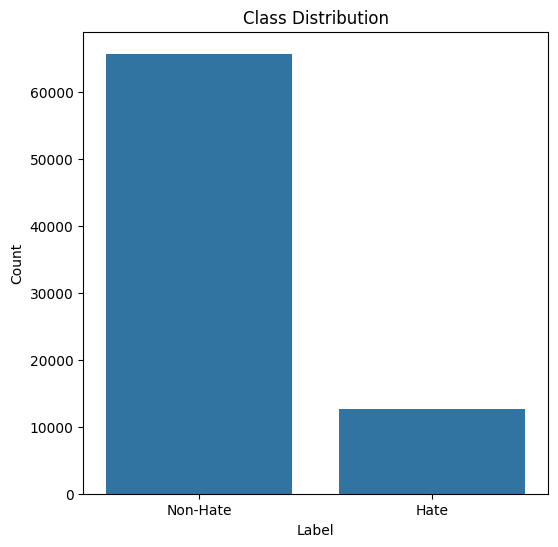

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Double check column name
print(hatespeech_df.columns.tolist())

plt.figure(figsize=(6, 6))
sns.countplot(x='Hate or Non Hate speech', data=hatespeech_df)
plt.xticks([0, 1], ['Non-Hate', 'Hate'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


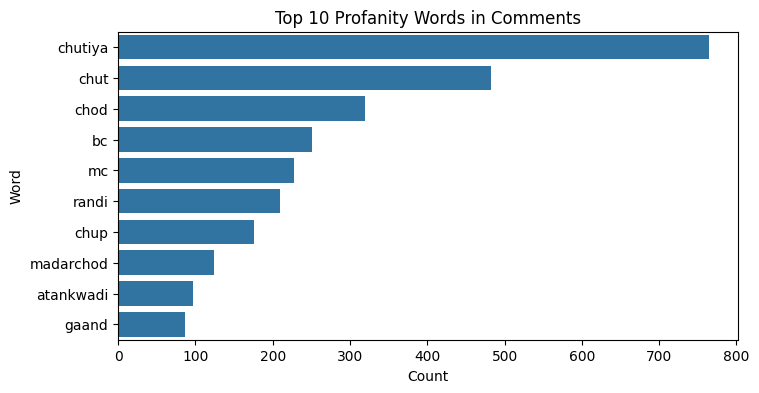

In [23]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Split all cleaned text into words
all_words = " ".join(hatespeech_df["Cleaned"]).split()

# Filter words that are in the profanity dictionary
profane_words = [word for word in all_words if word in profanity_dict]

# Count and plot top 10
top_profane = Counter(profane_words).most_common(10)

if top_profane:
    words, counts = zip(*top_profane)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title("Top 10 Profanity Words in Comments")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()
else:
    print("No profane words found in the cleaned text.")


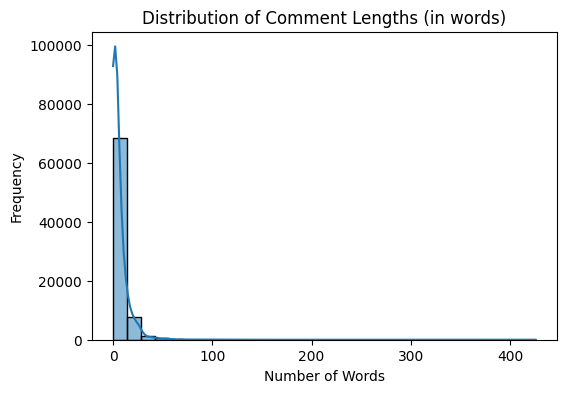

In [24]:
hatespeech_df['text_len'] = hatespeech_df['Cleaned'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.histplot(hatespeech_df['text_len'], bins=30, kde=True)
plt.title("Distribution of Comment Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


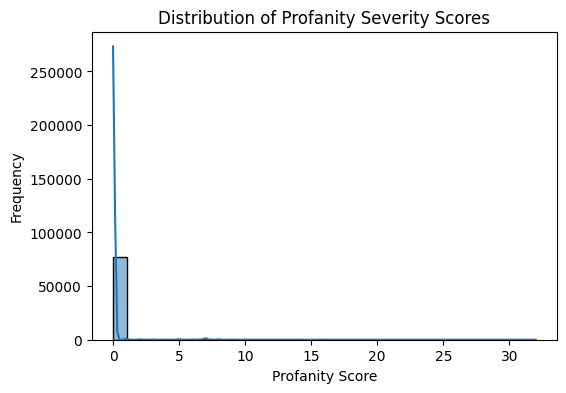

In [25]:
plt.figure(figsize=(6, 4))
sns.histplot(hatespeech_df['profanity_score'], bins=30, kde=True)
plt.title("Distribution of Profanity Severity Scores")
plt.xlabel("Profanity Score")
plt.ylabel("Frequency")
plt.show()


## Feature Extraction and Model Training

In [27]:
import joblib
import numpy as np
from src.features.embeddings import generate_sbert, generate_tfidf
from src.model.train_model import train_model
from sklearn.preprocessing import StandardScaler

# Step 1: Generate all features

# 1A. Encode text using SBERT
texts = hatespeech_df["Cleaned"].tolist()
sbert_vecs = generate_sbert(texts)

# 1B. Generate TF-IDF features
tfidf_model, tfidf_vecs = generate_tfidf(texts)

# 1C. Prepare and scale handcrafted features
handcrafted = hatespeech_df[["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]].values
scaler = StandardScaler()
handcrafted_scaled = scaler.fit_transform(handcrafted.astype(np.float32))

# 1D. Combine all features into final input matrix
X = np.hstack([sbert_vecs, tfidf_vecs, handcrafted_scaled])
y = hatespeech_df["Hate or Non Hate speech"].values

# Step 2: Train model using LightGBM with SMOTE
model, X_test, y_test = train_model(X , y, save_path="../models/comment_model.pkl")

# Step 3: Save the TF-IDF and scaler for inference
joblib.dump(tfidf_model, "../models/tfidf.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

Batches:   0%|          | 0/2452 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Number of positive: 49343, number of negative: 49279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.410625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 284658
[LightGBM] [Info] Number of data points in the train set: 98622, number of used features: 1272
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


['../models/scaler.pkl']

## Evaluate Model Performance

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     16469
           1       0.92      0.91      0.92     16405

    accuracy                           0.92     32874
   macro avg       0.92      0.92      0.92     32874
weighted avg       0.92      0.92      0.92     32874



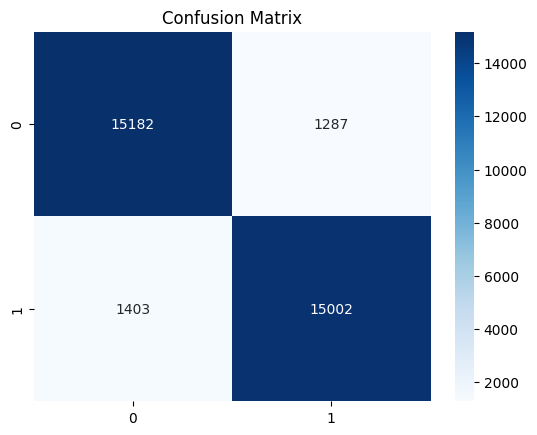

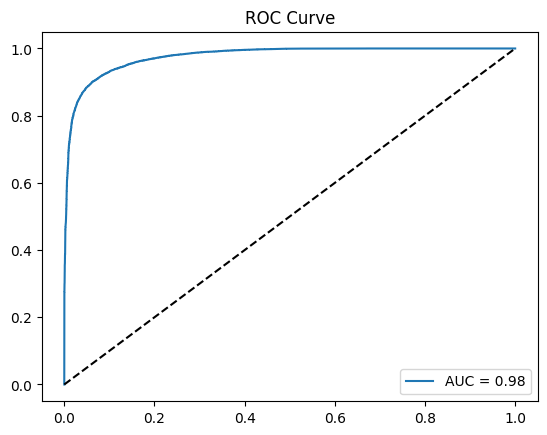

In [29]:
from src.model.evaluate_model import evaluate_model
 
# Predict labels and probabilities on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Display classification report, confusion matrix, and ROC curve
evaluate_model(y_test, y_pred, y_proba)

## Test on New comments

In [31]:
import pandas as pd
import numpy as np
import joblib
from src.preprocessing.text_cleaning import clean_text
from src.utils.profanity_utils import load_profanity_dict, extract_profanity_features
from src.features.embeddings import generate_sbert

# Step 1: Load trained artifacts
model = joblib.load("../models/comment_model.pkl")
tfidf = joblib.load("../models/tfidf.pkl")
scaler = joblib.load("../models/scaler.pkl")
profanity_dict = load_profanity_dict("../data/raw/Hinglish_Profanity_List.csv")

# Step 2: Custom code-mixed comments
comments = [
    "ye kya faltu harkat hai gandu",         # hate
    "bhai tu kitna stupid hai samajh nahi aata",  # non-hate
    "teri maa ka bhosdi",                    # hate
    "tumhara speech bahut galat tha. tujhe maarna chahiye", # hate
    "tujhe maarna chahiye"    # non-hate
]

# Step 3: Clean, extract features
df = pd.DataFrame({"Comment": comments})
df["Cleaned"] = df["Comment"].apply(clean_text)
profanity_feats = df["Cleaned"].apply(lambda x: pd.Series(extract_profanity_features(x, profanity_dict)))
profanity_feats.columns = ["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]

# Step 4: Generate embeddings and final feature matrix
sbert_vecs = generate_sbert(df["Cleaned"].tolist())
tfidf_vecs = tfidf.transform(df["Cleaned"]).toarray()
handcrafted_scaled = scaler.transform(profanity_feats.astype(np.float32))
X = np.hstack([sbert_vecs, tfidf_vecs, handcrafted_scaled])

# Step 5: Predict
df["Prediction"] = model.predict(X)
df["Confidence"] = model.predict_proba(X)[:, 1]
df["Label"] = df["Prediction"].map({0: "Non-Hate", 1: "Hate"})

# Final output
print(df[["Comment", "Label", "Confidence"]])


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                                             Comment     Label  Confidence
0                      ye kya faltu harkat hai gandu  Non-Hate    0.367714
1          bhai tu kitna stupid hai samajh nahi aata  Non-Hate    0.264863
2                                 teri maa ka bhosdi      Hate    0.819309
3  tumhara speech bahut galat tha. tujhe maarna c...  Non-Hate    0.157033
4                               tujhe maarna chahiye  Non-Hate    0.067941


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5



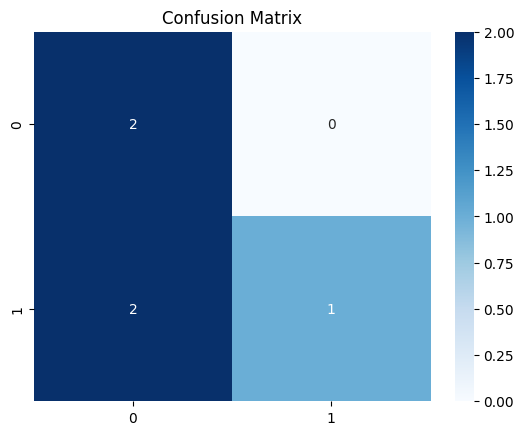

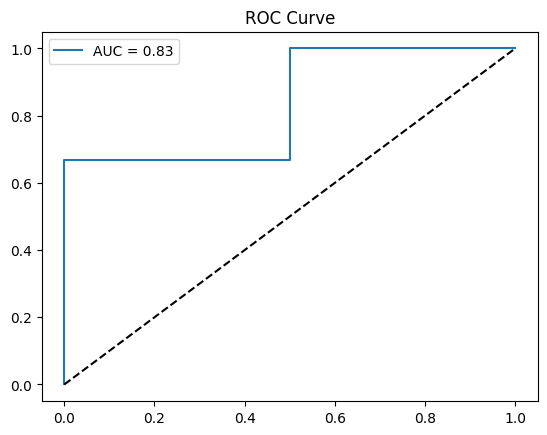

In [32]:
from src.model.evaluate_model import evaluate_model

# Example ground truth for 5 test comments
true_labels = [1, 0, 1, 1, 0]  # 1 = Hate, 0 = Non-Hate

# Use `df` from prediction code (already contains `y_pred` and `y_proba`)
y_pred = df["Prediction"].values
y_proba = df["Confidence"].values

# Evaluate predictions
evaluate_model(true_labels, y_pred, y_proba)


## Testing on text extracted from memes - EMOFF_MEME.csv

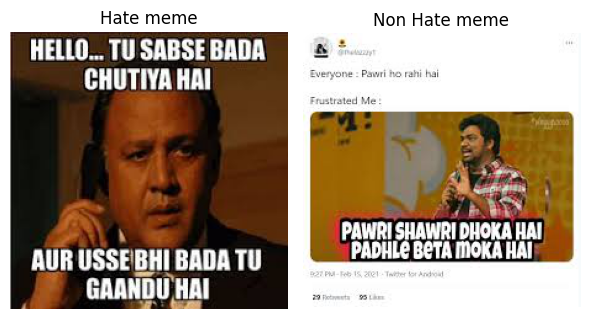

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

# Load images
img1 = Image.open("../data/raw/Emoff_meme/my_meme_data/babies184.png")
img2 = Image.open("../data/raw/Emoff_meme/my_meme_data/babies0.png")

# Plot side by side
plt.figure(figsize=(6, 4))  # Adjust size as needed

# First image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title("Hate meme")

# Second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title("Non Hate meme")

plt.tight_layout()
plt.show()

In [35]:
import pandas as pd

# Load both CSVs
df_emotions = pd.read_csv("../data/raw/Emoff_meme/EMOFF_MEME.csv")
df_emotions.drop(columns='text', inplace=True)

df_emotions.head()

,Name,Level1,Level2,Level 3(Emotion1),Level 4(Emotion2),Level 5(Emotion3)
0,hindi_meme0.png,1,1,Envy,Neglect,Rage
1,hindi_meme11.png,1,1,Rage,Disappointment,Envy
2,hindi_meme13.png,0,0,Joy,none,none
3,hindi_meme14.png,0,0,Joy,Rage,Sadness
4,hindi_meme16.png,0,0,Joy,Pride,none


In [36]:
import pandas as pd

# Load both CSVs
df_memeText = pd.read_csv("../data/preprocessed/extracted_memes_english_only.csv")


df_memeText.head()

,filename,comment,label
0,babies10.png,thlle,NaN
1,babies102.png,3a,NaN
2,babies0.png,NaN,NaN
3,babies100.png,nininibinis,NaN
4,babies101.png,NaN,NaN


In [37]:
# Merge 'comment' from df_memeText into df_emotions using 'Name' and 'filename'
merged_df = df_emotions.merge(
    df_memeText[['filename', 'comment']],
    how='left',
    left_on='Name',
    right_on='filename'
)

# Drop rows where 'comment' is NaN
filtered_df = merged_df[~merged_df['comment'].isna()].drop(columns=['filename', 'comment'])

# Now df_emotions is updated with only valid entries
df_emotions = filtered_df.reset_index(drop=True)

# Preview
print(df_emotions.head())

               Name  Level1  Level2 Level 3(Emotion1) Level 4(Emotion2)  \
0   hindi_meme0.png       1       1              Envy           Neglect   
1  hindi_meme11.png       1       1              Rage    Disappointment   
2  hindi_meme13.png       0       0               Joy              none   
3  hindi_meme14.png       0       0               Joy              Rage   
4  hindi_meme16.png       0       0               Joy             Pride   

  Level 5(Emotion3)  
0              Rage  
1              Envy  
2              none  
3           Sadness  
4              none  


In [38]:
# Step 1: Define hate-related emotions
HATE_EMOTIONS = {
    "Rage", "Disgust", "Anger", "Envy", "Fear",
    "Contempt", "Shame", "Neglect", "Disappointment"
}

# Step 2: Drop duplicates in df_emotions by 'Name' to ensure unique keys
df_unique_emotions = df_emotions.drop_duplicates(subset="Name", keep="first")

# Step 3: Create lookup dict
emotion_map = df_unique_emotions.set_index("Name")[[
    "Level1", "Level2",
    "Level 3(Emotion1)", "Level 4(Emotion2)", "Level 5(Emotion3)"
]].to_dict("index")

# Step 4: Label assignment function
def get_label(filename):
    row = emotion_map.get(filename)
    if not row:
        return None  # or 0 if you want to default missing entries to non-hate
    emotion = row["Level 3(Emotion1)"]
    if emotion in HATE_EMOTIONS:
        return 1
    return 0

# Step 5: Apply label assignment
df_memeText["label"] = df_memeText["filename"].apply(get_label)

# Step 6: Drop rows where label is NaN
df_memeText = df_memeText.dropna(subset=["label"])

# Step 7: Convert to integer
df_memeText["label"] = df_memeText["label"].astype(int)


In [39]:
df_memeText.head()

,filename,comment,label
0,babies10.png,thlle,0
1,babies102.png,3a,0
3,babies100.png,nininibinis,0
6,babies103.png,Phoolo ahT Taaron Ka Sabka chT Hai Ek R Kilo K...,0
8,babies107.png,Stinystep KITNI MOTI HOGYI HAI TU MOTI KISKO B...,0


In [40]:
df_memeText["label"].value_counts()

label
0    5087
1     894
Name: count, dtype: int64

In [41]:
print(df_memeText[df_memeText["label"] == 1].head(5))

          filename                                            comment  label
42   babies138.png                                                135      1
51   babies144.png                       t TRee www.trolitree.com Ill      1
90   babies184.png  HELLO..TUSABSEBADA CHUTIYA HAI AUR USSEBHI BAD...      1
139  babies226.png                                                 ay      1
154   babies24.png  Diwali  Rang fa Light's chKuch Logo Ki Yaad Aa...      1


In [42]:
def clean_text(text):
    text = str(text).lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+', '', text)     # remove URLs
    # text = re.sub(r'@\w+|#\w+', '', text)          # remove @mentions and #hashtags
    text = re.sub(r'[^\w\s,\.]', '', text)         # keep commas and periods
    return text

# Apply the function to every row in "Code mixed text" column
df_memeText["clean_comment"] = df_memeText["comment"].apply(clean_text)


In [43]:
# Extract context-aware profanity features from meme comments
# Only counts profanity if the usage targets a person/group
df_memeText[["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]] = \
    df_memeText["clean_comment"].apply(lambda x: pd.Series(extract_profanity_features(x, profanity_dict)))

# Drop original unprocessed comment column
df_memeText.drop(columns=["comment"], inplace=True)

# Preview extracted features for a few meme comments
print(df_memeText[["clean_comment", "profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]].sample(5, random_state=42))

# Preview full meme comment rows
df_memeText.sample(5, random_state=42)


                                          clean_comment  profanity_count  \
6562  rereae iye ihb w9h hle hst okes 1012 20 jokes1...              0.0   
6334  whatsspptext.com prize winning joke of the yea...              0.0   
4864                   jww.bittusharmajokes.com f.   lh              0.0   
7956                       hindian hindian_ f  hindian_              0.0   
278                                                   .              0.0   

      profanity_score  binary_profanity_match  normalized_text_len  
6562              0.0                     0.0                 0.10  
6334              0.0                     0.0                 0.31  
4864              0.0                     0.0                 0.03  
7956              0.0                     0.0                 0.04  
278               0.0                     0.0                 0.01  


,filename,label,clean_comment,profanity_count,profanity_score,binary_profanity_match,normalized_text_len
6562,non_off2.png,0,rereae iye ihb w9h hle hst okes 1012 20 jokes1...,0.0,0.0,0.0,0.10
6334,modei_shah123.png,0,whatsspptext.com prize winning joke of the yea...,0.0,0.0,0.0,0.31
4864,m_117.png,0,jww.bittusharmajokes.com f. lh,0.0,0.0,0.0,0.03
7956,rel387.png,0,hindian hindian_ f hindian_,0.0,0.0,0.0,0.04
278,babies352.png,0,.,0.0,0.0,0.0,0.01


['filename', 'label', 'clean_comment', 'profanity_count', 'profanity_score', 'binary_profanity_match', 'normalized_text_len']


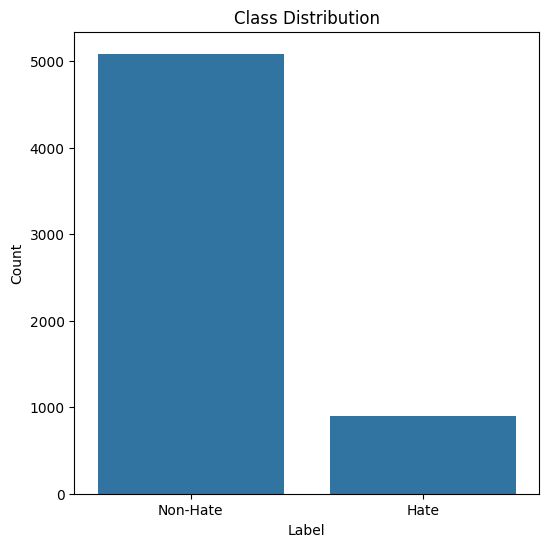

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Double check column name
print(df_memeText.columns.tolist())

plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=df_memeText)
plt.xticks([0, 1], ['Non-Hate', 'Hate'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

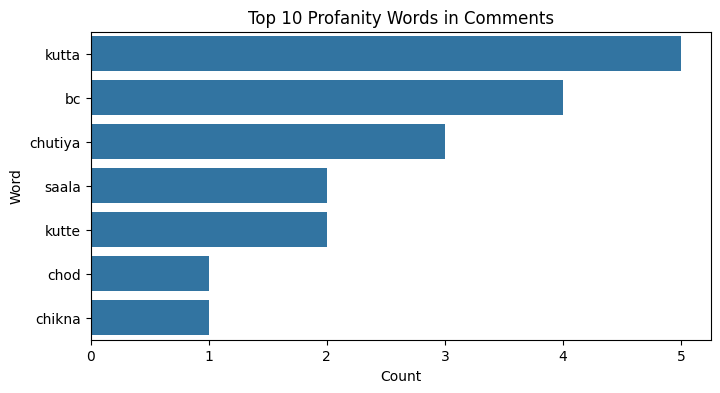

In [45]:
from collections import Counter

# Split all cleaned text into words
all_words = " ".join(df_memeText["clean_comment"]).split()

# Filter words that are in the profanity dictionary
profane_words = [word for word in all_words if word in profanity_dict]

# Count and plot top 10
top_profane = Counter(profane_words).most_common(10)

if top_profane:
    words, counts = zip(*top_profane)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title("Top 10 Profanity Words in Comments")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()
else:
    print("No profane words found in the cleaned text.")


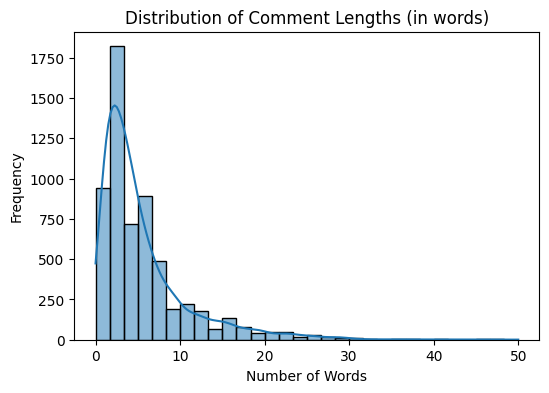

In [46]:
df_memeText['text_len'] = df_memeText['clean_comment'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6, 4))
sns.histplot(df_memeText['text_len'], bins=30, kde=True)
plt.title("Distribution of Comment Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


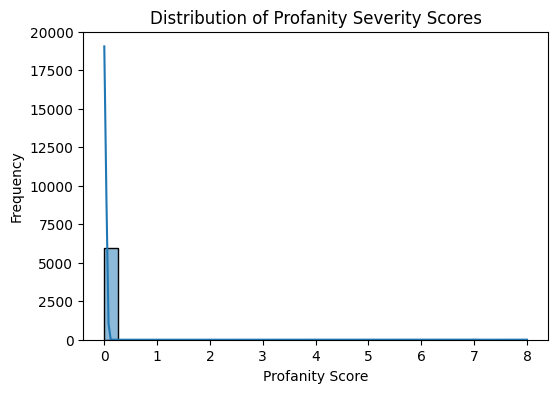

In [47]:
plt.figure(figsize=(6, 4))
sns.histplot(df_memeText['profanity_score'], bins=30, kde=True)
plt.title("Distribution of Profanity Severity Scores")
plt.xlabel("Profanity Score")
plt.ylabel("Frequency")
plt.show()


Batches:   0%|          | 0/187 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3830, number of negative: 3800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200104
[LightGBM] [Info] Number of data points in the train set: 7630, number of used features: 1034
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
              precision    recall  f1-score   support

    Non-Hate       0.90      0.93      0.91      1287
        Hate       0.92      0.89      0.91      1257

    accuracy                           0.91      2544
   macro avg       0.91      0.91      0.91      2544
weighted avg       0.91      0.91      0.91      2544



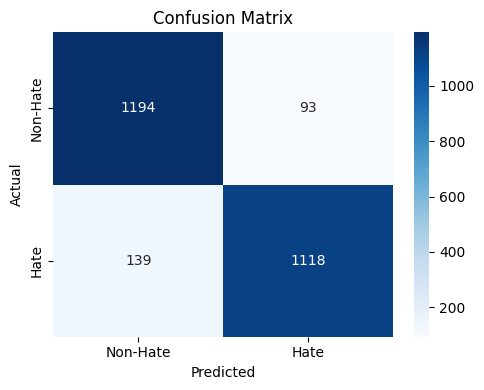

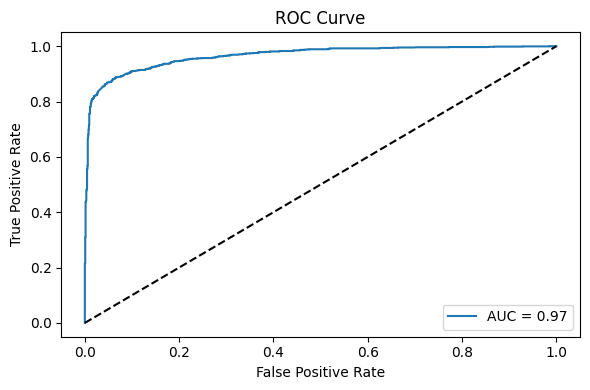

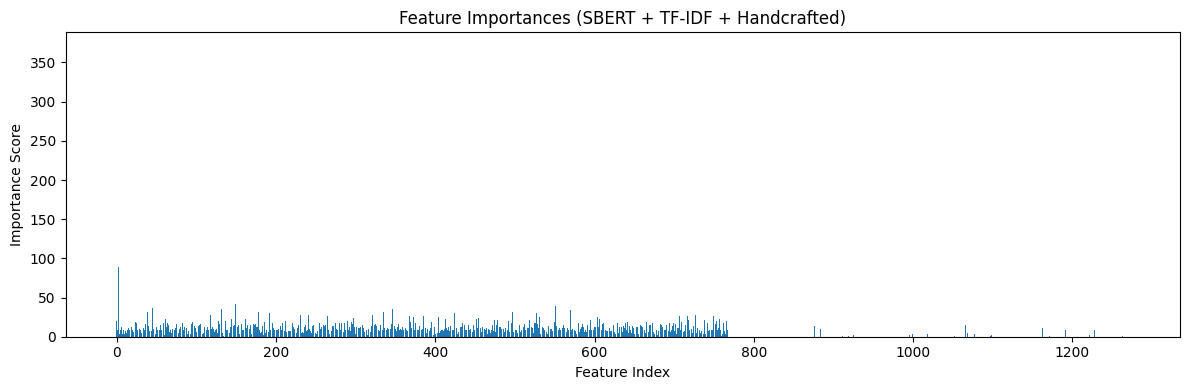

In [48]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your dataset (replace this with your actual data loading)
# Example: hatespeech_df = pd.read_csv("your_data.csv")

# Encode SBERT embeddings
sbert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
texts = df_memeText["clean_comment"].tolist()
text_embeddings = sbert_model.encode(texts, show_progress_bar=True)

# Generate TF-IDF features (1-2 grams, top 500 features)
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=500)
tfidf_features = tfidf.fit_transform(df_memeText["clean_comment"]).toarray()

# Prepare and scale handcrafted features
handcrafted = df_memeText[["profanity_count", "profanity_score", "binary_profanity_match", "normalized_text_len"]].values
scaler = StandardScaler()
handcrafted_scaled = scaler.fit_transform(handcrafted.astype(np.float32))

# Combine SBERT + TF-IDF + handcrafted features
X = np.hstack([
    np.array(text_embeddings).astype(np.float32),
    tfidf_features.astype(np.float32),
    handcrafted_scaled
])
y = df_memeText["label"].values

# Balance classes using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# Train LightGBM
clf = LGBMClassifier(
    n_estimators=150,
    learning_rate=0.05,
    num_leaves=64,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred, target_names=["Non-Hate", "Hate"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Feature importance
importances = clf.feature_importances_
plt.figure(figsize=(12, 4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances (SBERT + TF-IDF + Handcrafted)")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()
